
# Assignment 1 — Personal Data Vis (Git Commit Archive)

This notebook loads my Git commit archive, performs basic cleaning/feature extraction, and generates initial visuals.
It is safe to share: sensitive identifiers have been removed or aggregated.



## 1. Setup


In [112]:
import os, re, textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import colorspacious as cs
from colorspacious import cspace_convert
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import squarify
import squarify
from datetime import datetime

# Compatibility: restore np.asscalar for older libraries if missing
if not hasattr(np, 'asscalar'):
    def _asscalar(x):
        try:
            return x.item()
        except Exception:
            return np.array(x).item()
    np.asscalar = _asscalar

In [91]:
CSV_PATH = "data/commits_history.csv"

assert os.path.exists(CSV_PATH), "Dataset not found."
df = pd.read_csv(CSV_PATH)
df.head()


,repo_full_name,repo_private,repo_language,repo_stars,repo_forks,commit_day,commit_hour,message,is_merge
0,Samuel-Chapuis/4Vegetation,False,Java,0,0,2025-05-15,9,Test(item): God pickaxe,False
1,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,fix ( blocks ) : few texture and logic patches,False
2,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,feat ( block ) : GrappeVine with and without g...,False
3,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,21,feat ( block ) : Big lily pad,False
4,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-22,22,texture change,False


In [92]:
df['is_in_the_USA'] = np.where(
    (df['commit_day'] >= '2025-01-01') & (df['commit_day'] <= '2025-06-01'),
    'oui',
    'non'
)
df.head()

,repo_full_name,repo_private,repo_language,repo_stars,repo_forks,commit_day,commit_hour,message,is_merge,is_in_the_USA
0,Samuel-Chapuis/4Vegetation,False,Java,0,0,2025-05-15,9,Test(item): God pickaxe,False,oui
1,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,fix ( blocks ) : few texture and logic patches,False,non
2,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,feat ( block ) : GrappeVine with and without g...,False,non
3,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,21,feat ( block ) : Big lily pad,False,non
4,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-22,22,texture change,False,non


In [93]:
def split_message(msg):
    if pd.isna(msg):
        return None, None, None
    msg = str(msg).strip()
    before = None
    between = None
    after = msg
    before_match = re.match(r'^(.*?)\s*\(', msg)
    if before_match:
        before = before_match.group(1).strip().lower()
        between_match = re.search(r'\((.*?)\)', msg)
        if between_match:
            between = between_match.group(1).strip().lower()
            after_start = between_match.end()
            after_part = msg[after_start:].strip()
            if ':' in after_part:
                after = after_part.split(':', 1)[1].strip()
            else:
                after = after_part
    if ':' in msg and after == msg:
        after = msg.split(':', 1)[1].strip()
    return before, between, after

df[['message_type', 'message_argument', 'message_message']] = df['message'].apply(lambda x: pd.Series(split_message(x)))
df = df.drop(columns=['message'])
df.head()

,repo_full_name,repo_private,repo_language,repo_stars,repo_forks,commit_day,commit_hour,is_merge,is_in_the_USA,message_type,message_argument,message_message
0,Samuel-Chapuis/4Vegetation,False,Java,0,0,2025-05-15,9,False,oui,test,item,God pickaxe
1,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,False,non,fix,blocks,few texture and logic patches
2,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,False,non,feat,block,GrappeVine with and without grapes
3,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,21,False,non,feat,block,Big lily pad
4,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-22,22,False,non,None,None,texture change


In [94]:
df.to_csv("data/commits_history_cleaned.csv", index=False)

## 2. Basic checks

In [95]:

n_rows, n_cols = df.shape
print("Shape:", n_rows, "rows ×", n_cols, "cols")
df.dtypes


Shape: 459 rows × 12 cols


repo_full_name      object
repo_private          bool
repo_language       object
repo_stars           int64
repo_forks           int64
commit_day          object
commit_hour          int64
is_merge              bool
is_in_the_USA       object
message_type        object
message_argument    object
message_message     object
dtype: object

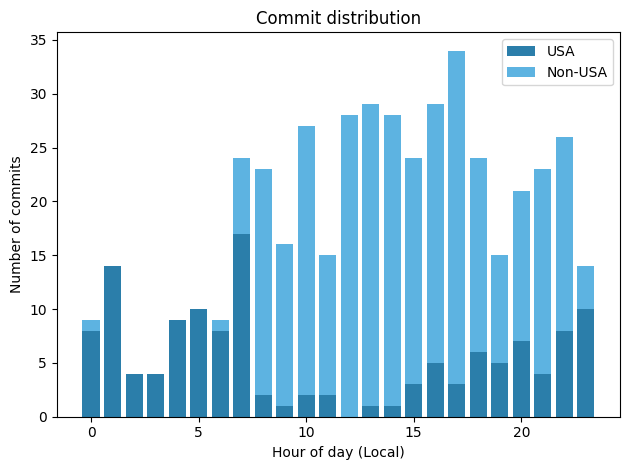

In [96]:
# Compute hour counts (needed before plotting)
hour_counts_usa = df[df['is_in_the_USA'] == 'oui']['commit_hour'].value_counts().sort_index()
hour_counts_non_usa = df[df['is_in_the_USA'] == 'non']['commit_hour'].value_counts().sort_index()
# Align both series to the same index (all possible hours)
all_hours = sorted(set(hour_counts_usa.index).union(set(hour_counts_non_usa.index)))
usa_counts_aligned = hour_counts_usa.reindex(all_hours, fill_value=0)
non_usa_counts_aligned = hour_counts_non_usa.reindex(all_hours, fill_value=0)

plt.figure()
plt.bar(all_hours, usa_counts_aligned.values, color="#2b7eaa", label='USA')
plt.bar(all_hours, non_usa_counts_aligned.values,
        bottom=usa_counts_aligned.values,
        color="#5db3e1",  # bleu clair au lieu de orange
        label='Non-USA')
plt.xlabel("Hour of day (Local)")
plt.ylabel("Number of commits")
plt.title("Commit distribution")
plt.legend()
plt.tight_layout()
plt.show()


In [97]:
df.loc[df['is_in_the_USA'] == 'oui', 'commit_hour'] = (df.loc[df['is_in_the_USA'] == 'oui', 'commit_hour'] + 10) % 24
df.head()

,repo_full_name,repo_private,repo_language,repo_stars,repo_forks,commit_day,commit_hour,is_merge,is_in_the_USA,message_type,message_argument,message_message
0,Samuel-Chapuis/4Vegetation,False,Java,0,0,2025-05-15,19,False,oui,test,item,God pickaxe
1,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,False,non,fix,blocks,few texture and logic patches
2,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,22,False,non,feat,block,GrappeVine with and without grapes
3,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-23,21,False,non,feat,block,Big lily pad
4,Samuel-Chapuis/4Vegetation,False,Java,0,0,2024-12-22,22,False,non,None,None,texture change


In [98]:
# Recalculer les comptages après ajustement des heures
hour_counts_usa = df[df['is_in_the_USA'] == 'oui']['commit_hour'].value_counts().sort_index()
hour_counts_non_usa = df[df['is_in_the_USA'] == 'non']['commit_hour'].value_counts().sort_index()

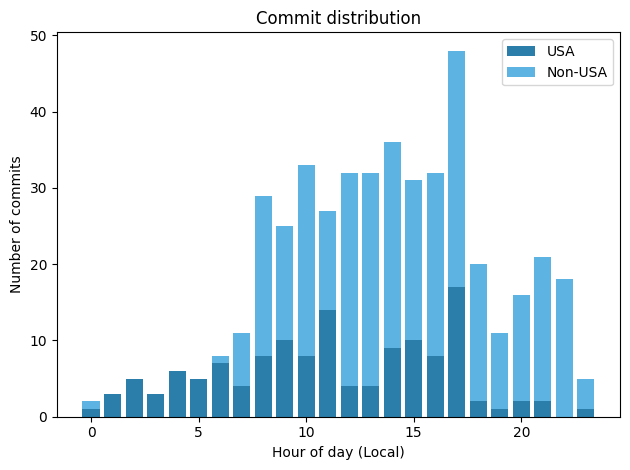

In [99]:
# Align both series to the same index (all possible hours)
all_hours = sorted(set(hour_counts_usa.index).union(set(hour_counts_non_usa.index)))
usa_counts_aligned = hour_counts_usa.reindex(all_hours, fill_value=0)
non_usa_counts_aligned = hour_counts_non_usa.reindex(all_hours, fill_value=0)

plt.figure()
plt.bar(all_hours, usa_counts_aligned.values, color="#2b7eaa", label='USA')
plt.bar(all_hours, non_usa_counts_aligned.values,
        bottom=usa_counts_aligned.values,
        color="#5db3e1",  # bleu clair au lieu de orange
        label='Non-USA')
plt.xlabel("Hour of day (Local)")
plt.ylabel("Number of commits")
plt.title("Commit distribution")
plt.legend()
plt.tight_layout()
plt.show()


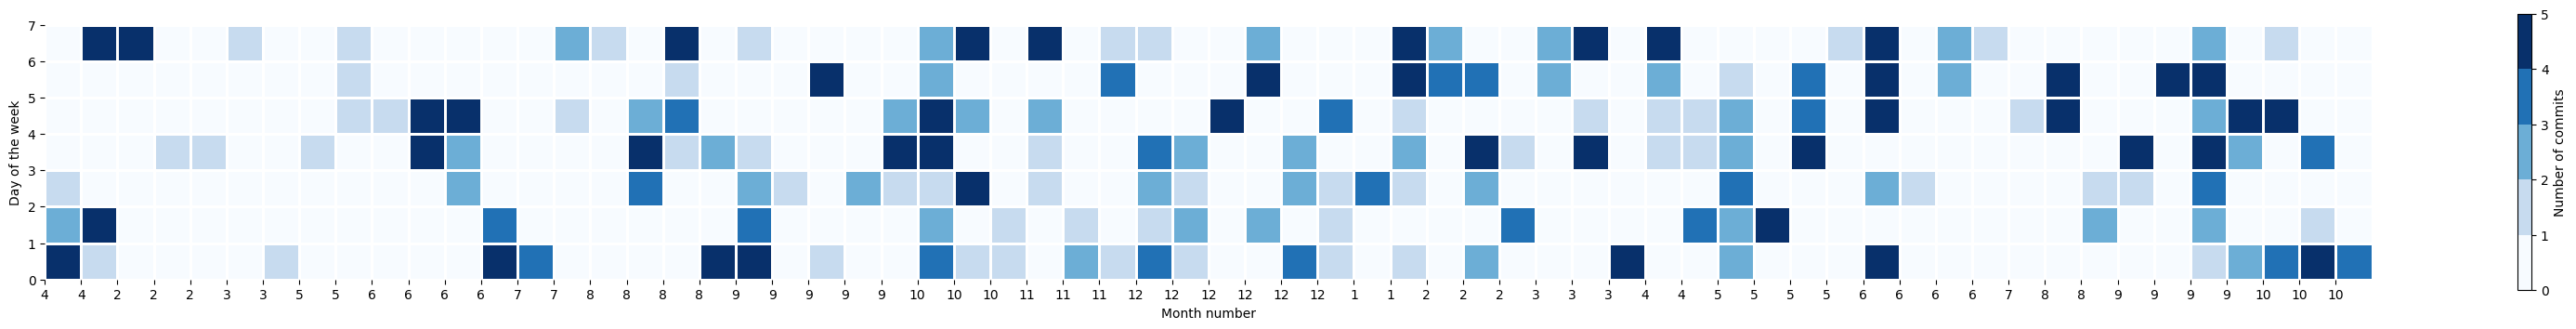

In [100]:
# Préparer les données pour la heatmap
df['commit_day'] = pd.to_datetime(df['commit_day'])
df['dow'] = df['commit_day'].dt.dayofweek  # 0 = Lundi
df['week'] = (df['commit_day'] - df['commit_day'].min()).dt.days // 7

# Compter les commits par jour de semaine et semaine
commit_counts = df.groupby(['dow', 'week']).size().unstack(fill_value=0)

# Obtenir le mois pour chaque semaine
week_months = df.groupby('week')['commit_day'].first().dt.to_period('M')

# Créer la matrice
matrix = commit_counts.values  # Shape (7, n_weeks)

# Échelle discrète
boundaries = [0, 1, 2, 3, 4, 5]
cmap = plt.cm.Blues
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

n_weeks = matrix.shape[1]
fig, ax = plt.subplots(figsize=(max(16, n_weeks * 0.5), max(3, 7 * 0.5)))
c = ax.pcolormesh(matrix, cmap=cmap, norm=norm, edgecolors='white', linewidth=2)
ax.set_aspect('equal')

# Enlever le cadre
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.colorbar(c, ax=ax, label='Number of commits', boundaries=boundaries, ticks=boundaries)
ax.set_xlabel('Month number')
ax.set_ylabel('Day of the week')
ax.set_xticks(range(n_weeks))
ax.set_xticklabels([week_months.get(w, pd.Period('1900-01', 'M')).month for w in commit_counts.columns], rotation=0)
plt.tight_layout()
plt.show()

# Assignment 2 — Choosing Colors

In [101]:
# Afficher la liste des catégories de la colonne repo_language (tolérance pour typo)
col = 'repo_language' if 'repo_language' in df.columns else 'repo_langange'
categories = df[col].dropna().unique().tolist()
print(categories)

['Java', 'Jupyter Notebook', 'JavaScript', 'Kotlin', 'C++', 'HTML', 'Python', 'TeX', 'C']


### Colorblind check function
Here I created some function to visualize rapidly if a color palet is differentiable for a Colorblind persone through a matrix

In [102]:
def color_distance(hex1, hex2):
    # create sRGBColor objects from hex and convert to LabColor before computing delta E
    srgb1 = sRGBColor.new_from_rgb_hex(hex1)
    srgb2 = sRGBColor.new_from_rgb_hex(hex2)
    lab1 = convert_color(srgb1, LabColor)
    lab2 = convert_color(srgb2, LabColor)
    return delta_e_cie2000(lab1, lab2)

def color_list_distance(color_list):
    n = len(color_list)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i, j] = color_distance(color_list[i], color_list[j])
            else:
                distances[i, j] = 0.0
    return distances

def plot_red_green_matrix(matrix, color_list, vmin=5, vmax=40, figsize=(6,6), annot=False):
    n = len(color_list)
    cmap = mcolors.LinearSegmentedColormap.from_list('red_green', ["#da5151", "#51bc51"])

    # Étendre la matrice : +2 pour ajouter un séparateur blanc
    extended_matrix = np.full((n+2, n+2), np.nan)
    extended_matrix[2:, 2:] = matrix  # décalée de 2 pour laisser la place aux couleurs + séparateur

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(extended_matrix, cmap=cmap, vmin=vmin, vmax=vmax, aspect='equal')

    # Supprimer les ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Ajouter les carrés de couleur (haut et gauche)
    for i, color in enumerate(color_list):
        # ligne du haut (colonne i+2)
        rect_top = Rectangle((i+1.5, -0.5), 1, 1, facecolor=color, edgecolor='none')
        ax.add_patch(rect_top)
        # colonne de gauche (ligne i+2)
        rect_left = Rectangle((-0.5, i+1.5), 1, 1, facecolor=color, edgecolor='none')
        ax.add_patch(rect_left)

    # Ajouter le séparateur blanc (ligne + colonne)
    # Ligne horizontale blanche entre les couleurs du haut et la matrice
    rect_sep_h = Rectangle((0.5, 0.5), n+1, 1, facecolor='white', edgecolor='none', zorder=3)
    ax.add_patch(rect_sep_h)
    # Colonne verticale blanche entre les couleurs de gauche et la matrice
    rect_sep_v = Rectangle((0.5, 0.5), 1, n+1, facecolor='white', edgecolor='none', zorder=3)
    ax.add_patch(rect_sep_v)

    # Tracer la diagonale grise
    for i in range(n):
        rect = Rectangle((i+1.5, i+1.5), 1, 1, facecolor='lightgray', edgecolor='white', linewidth=1)
        ax.add_patch(rect)

    # Annotations optionnelles
    if annot:
        for (i, j), val in np.ndenumerate(matrix):
            ax.text(j+2, i+2, f'{val:.1f}', ha='center', va='center', fontsize=8, color='black')

    # Barre de couleur
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(f'Value (clipped to [{vmin}, {vmax}])')
    cbar.set_ticks(np.linspace(vmin, vmax, 5))

    plt.tight_layout()
    plt.show()

In [103]:
def plot_color_distance_upper(color_list, vmin=10, vmax=30, annotate=True, title="Distances de couleurs (ΔE00)"):
    """
    Trace la matrice des distances de couleur (ΔE00) sur la diagonale supérieure.
    - Axe Y : carrés colorés à gauche
    - Axe X : carrés colorés directement collés en bas, avec code hex dessous
    """
    n = len(color_list)
    distances = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i, j] = color_distance(color_list[i], color_list[j])

    # masque diagonale + triangle inférieur
    mask = np.tri(n, n, k=0, dtype=bool)
    m = np.ma.masked_array(distances, mask=mask)

    # colormap rouge→vert
    cmap = LinearSegmentedColormap.from_list("red_to_green", ["#ff0000", "#00ff00"])
    cmap.set_bad((1, 1, 1, 0))

    # figure
    fig, ax = plt.subplots(figsize=(1.1*n + 2, 1.1*n + 2))
    im = ax.imshow(m, cmap=cmap, vmin=vmin, vmax=vmax, origin="upper")

    # axes sans texte
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels([""] * n)
    ax.set_yticklabels([""] * n)

    # carrés colorés à gauche (axe Y)
    for i, col in enumerate(color_list):
        ax.add_patch(Rectangle((-1.3, i-0.5), 0.8, 1,
                               color=col, transform=ax.transData, clip_on=False))

    # carrés colorés en bas (axe X) : collés à la matrice
    y_offset = n - 0.5  # position juste sous la dernière ligne visible
    for i, col in enumerate(color_list):
        # carré coloré collé sous la matrice
        ax.add_patch(Rectangle((i-0.5, y_offset), 1, 0.8,
                               color=col, transform=ax.transData, clip_on=False))
        # texte sous le carré
        ax.text(i, y_offset + 0.9, color_list[i],
                ha="center", va="top", fontsize=9)

    # grille légère
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", linestyle=":", linewidth=0.5, alpha=0.6)
    ax.tick_params(which="minor", bottom=False, left=False)

    # annotations numériques
    if annotate:
        for i in range(n):
            for j in range(i+1, n):
                val = distances[i, j]
                txt = ax.text(j, i, f"{val:.1f}",
                              ha="center", va="center", fontsize=9, color="black")
                txt.set_path_effects([pe.withStroke(linewidth=2, foreground="white")])

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Distance (ΔE00)")
    cbar.set_ticks([vmin, (vmin+vmax)/2, vmax])

    ax.set_title(title)
    plt.tight_layout()
    plt.show()


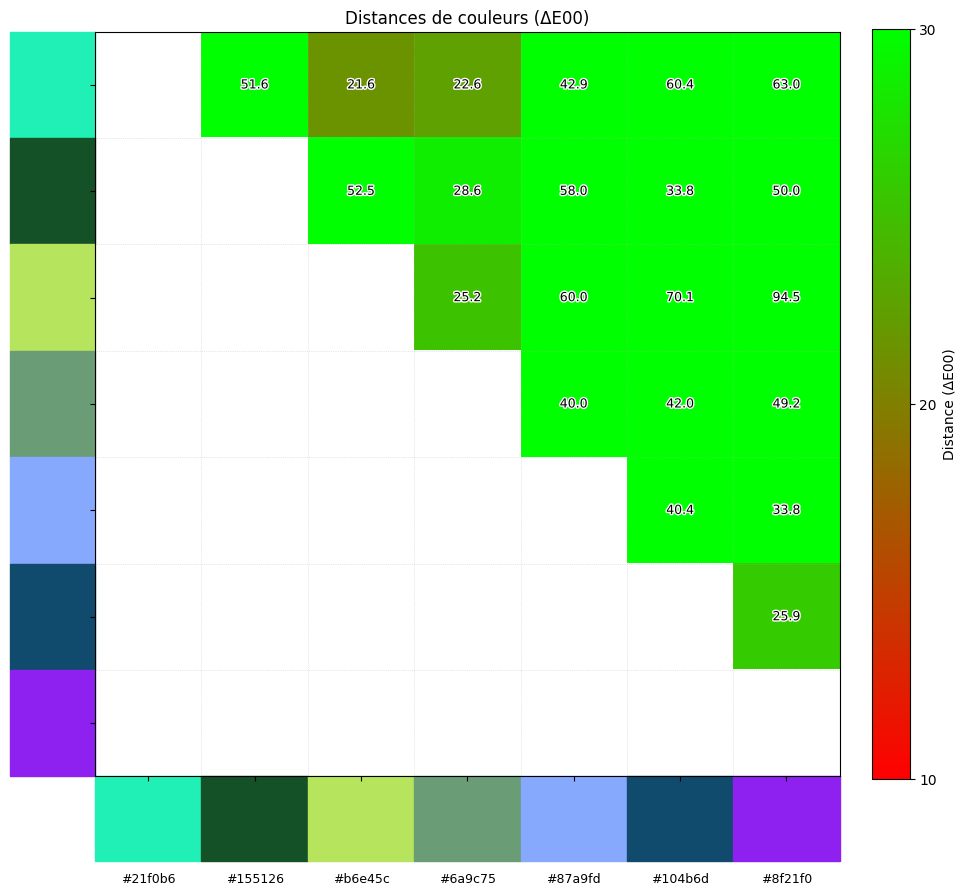

In [129]:
color_list = ["#41bbc5", "#befcfa", "#81aa49", "#abf774", "#20b647", "#24ffcd", "#f3f798"]
color_list = ["#21f0b6", "#155126", "#b6e45c", "#6a9c75", "#87a9fd", "#104b6d",  "#8f21f0"]
dist_matrix = color_list_distance(color_list)
# plot_red_green_matrix(dist_matrix, color_list, vmin=0, vmax=20, figsize=(6,6), annot=True)
plot_color_distance_upper(color_list, vmin=10, vmax=30, annotate=True)

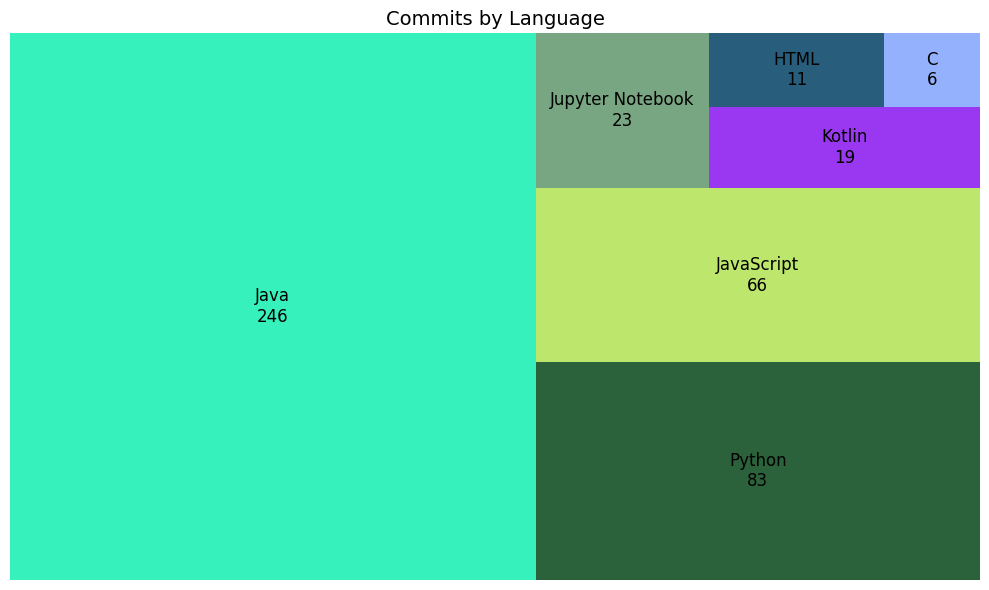

In [125]:
# Compter les langages
lang_counts = df['repo_language'].value_counts().head(7)

# Associer les couleurs à chaque langage
palette = {lang: color_list[i % len(color_list)] for i, lang in enumerate(lang_counts.index)}
colors = [palette.get(lang, '#777777') for lang in lang_counts.index]

# Créer la treemap
plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=lang_counts.values,
    label=[f"{lang}\n{count}" for lang, count in zip(lang_counts.index, lang_counts.values)],
    color=colors,
    alpha=0.9,
    text_kwargs={'fontsize': 12, 'weight': 'normal', 'color': 'black'}  # <-- on retire 'va'
)

plt.title("Commits by Language", fontsize=14, weight='normal')
plt.axis('off')
plt.tight_layout()
plt.show()


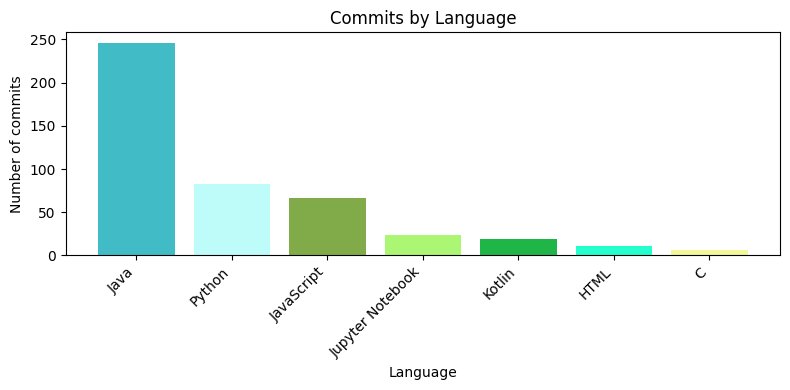

In [106]:
lang_counts = df['repo_language'].value_counts().head(7)

# Map top languages to colors from the existing color_list (wrap if needed)
palette = {lang: color_list[i % len(color_list)] for i, lang in enumerate(lang_counts.index)}

colors = [palette.get(lang, '#777777') for lang in lang_counts.index]

plt.figure(figsize=(8,4))
plt.bar(lang_counts.index, lang_counts.values, color=colors)
plt.xlabel('Language')
plt.ylabel('Number of commits')
plt.title('Commits by Language')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
